<h1>In this notebook, we would correct the reference map derived by NODDI Matlab Toolbox</h1>
I suggest that the regions where voxels having FWF ~= 1 should have 0 value of NDI and ODI. Because those voxels are all free-water volumes, there is no interested microstructure.</br>

In [1]:
import nibabel as nib
import numpy as np
import os
"""
packages that does conventional model fitting
"""
import amico
"""
packages that generate train/test dataset
"""
from FormatData import generate_data, parser as data_parser
"""
packages that produce the rejection shceme
"""
from filter_qa import parser as filter_parser, load_eddy
"""
package to store the intermediate result
"""
import pickle
"""
package to work out RMSE and SSIM
"""
from utils import calc_RMSE, calc_ssim, load_nii_image, show_slices

2022-06-27 17:13:05.175630: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


------
<h4>Try on a subject first</h4>
Firstly, try on subject 1

In [7]:
s01_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/'
s01_old_ndi = os.path.join(s01_path, 's01_still_NDI.nii')
s01_old_odi = os.path.join(s01_path, 's01_still_ODI.nii')
s01_old_fwf = os.path.join(s01_path, 's01_still_FWF.nii')

In [8]:
s01_ndi_aff = nib.load(s01_old_odi).affine
s01_old_ndi = nib.load(s01_old_ndi).get_fdata()

s01_odi_aff = nib.load(s01_old_odi).affine
s01_old_odi = nib.load(s01_old_odi).get_fdata()

s01_fwf_aff  = nib.load(s01_old_fwf).affine
s01_old_fwf = nib.load(s01_old_fwf).get_fdata()

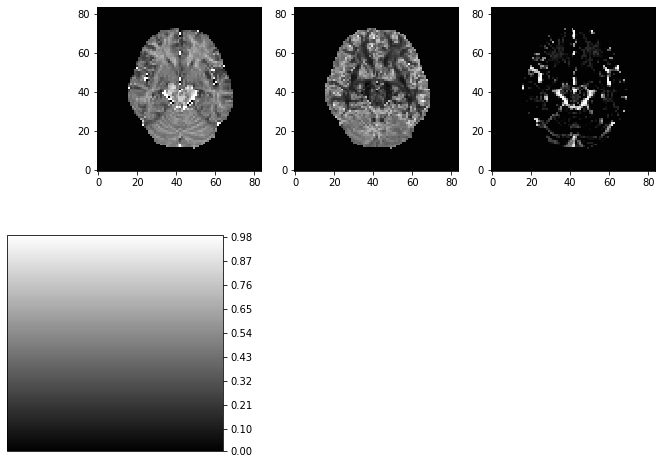

In [9]:
show_slices([s01_old_ndi[:, :, 16], s01_old_odi[:, :, 16], s01_old_fwf[:, :, 16]], grayscale=True)

------
Let's correct the voxels, by making the voxels whose FWF ~= 1 to have NDI and ODI = 0

In [10]:
# get s01 mask
s01_filtered_mask = nib.load(s01_path+'filtered_mask.nii').get_fdata()
s01_mask = nib.load(s01_path+'mask-e.nii').get_fdata()
shape = s01_mask.shape

s01_mask = s01_mask.flatten()
s01_filtered_mask = s01_filtered_mask.flatten()

s01_new_ndi = s01_old_ndi.copy()
s01_new_ndi = s01_new_ndi.reshape(s01_mask.shape[0])
s01_new_odi = s01_old_odi.copy()
s01_new_odi = s01_new_odi.reshape(s01_mask.shape[0])

for i in range(len(s01_filtered_mask)):
    if s01_filtered_mask[i] == 0:
        # if the filtered mask does not have these voxels, they have NDI and ODI values 0
        s01_new_ndi[i] = 0.0
        s01_new_odi[i] = 0.0

# reshape ndi and odi back
s01_new_ndi = s01_new_ndi.reshape(shape)
s01_new_odi = s01_new_odi.reshape(shape)

Let's visualise the corrected ndi and odi

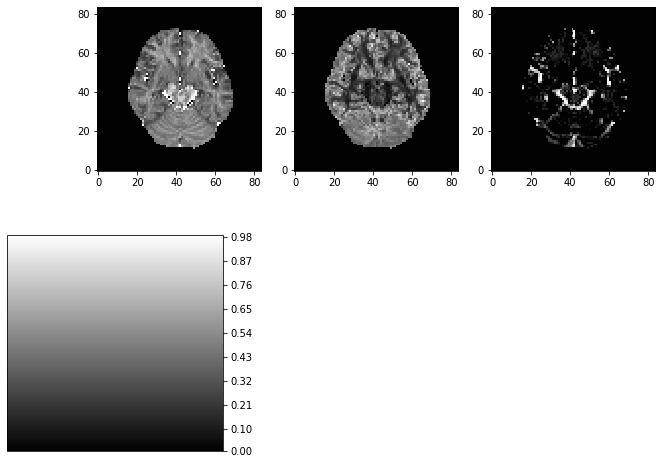

In [11]:
show_slices([s01_new_ndi[:, :, 16], s01_new_odi[:, :, 16], s01_old_fwf[:, :, 16]], grayscale=True)

Let's save the produced parameter map and check it on fsl

In [12]:
s01_new_ndi = nib.Nifti1Image(s01_new_ndi, s01_ndi_aff)
nib.save(s01_new_ndi, s01_path+'corrected_ndi.nii')

s01_new_odi = nib.Nifti1Image(s01_new_odi, s01_odi_aff)
nib.save(s01_new_odi, s01_path+'corrected_odi.nii')

-------
Ready to turn this into a function

In [13]:
def correct_ref(subject_path):
    subject = subject_path.split('/')[-1]
    old_ndi = os.path.join(subject_path, subject+'_NDI.nii')
    old_odi = os.path.join(subject_path, subject+'_ODI.nii')
    old_fwf = os.path.join(subject_path, subject+'_FWF.nii')

    ndi_aff = nib.load(old_ndi).affine
    old_ndi = nib.load(old_ndi).get_fdata()

    odi_aff = nib.load(old_odi).affine
    old_odi = nib.load(old_odi).get_fdata()

    fwf_aff  = nib.load(old_fwf).affine
    old_fwf = nib.load(old_fwf).get_fdata()

    os.path.join(subject_path, 'filtered_mask.nii')
    filtered_mask = nib.load(os.path.join(subject_path, 'filtered_mask.nii')).get_fdata()
    ori_mask = nib.load(os.path.join(subject_path, 'mask-e.nii')).get_fdata()
    shape = ori_mask.shape

    ori_mask = ori_mask.flatten()
    filtered_mask = filtered_mask.flatten()

    new_ndi = old_ndi.copy()
    new_ndi = new_ndi.reshape(ori_mask.shape[0])
    new_odi = old_odi.copy()
    new_odi = new_odi.reshape(ori_mask.shape[0])

    for i in range(len(filtered_mask)):
        if filtered_mask[i] == 0:
            # if the filtered mask does not have these voxels, they have NDI and ODI values 0
            new_ndi[i] = 0.0
            new_odi[i] = 0.0

    # reshape ndi and odi back
    new_ndi = new_ndi.reshape(shape)
    new_odi = new_odi.reshape(shape)

    # save the new ndi and odi map
    new_ndi = nib.Nifti1Image(new_ndi, ndi_aff)
    nib.save(new_ndi, os.path.join(subject_path, 'corrected_ndi.nii'))

    new_odi = nib.Nifti1Image(new_odi, odi_aff)
    nib.save(new_odi, os.path.join(subject_path, 'corrected_odi.nii'))

In [14]:
paths = ['/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still', '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s02_still',
        '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_still_reg', '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_still_reg']

for path in paths:
    correct_ref(path)